In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import sklearn
from functools import partial
from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

# import umap
# import hdbscan
# from mdutils.mdutils import MdUtils

FLP_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project').absolute()
sys.path.insert(1, str(FLP_path))


from py.dec.dec_torch.dec import DEC
from py.dec.dec_torch.cluster_loops import train, predict
from py.dec.dec_torch.sdae import StackedDenoisingAutoEncoder
from py.dec.dec_torch.utils import cluster_accuracy, target_distribution
from py.datasets.mnist import CachedMNIST, ReconstructedMNIST

import py.metrics as my_metrics
from py.util import compute_centroid_np, get_dims_from_weights

results_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project/out_torch/mnist/tied/bce/mix/b5')
N_CLUSTERS = 10

torch.cuda.set_device(7)
cuda = True
testing_mode = False
is_tied = True

In [2]:
ae_param_path = results_path/'pretrain_ae'
ae_param_ft_path = results_path/'finetune_ae'
ae_alpha1_param_final_path = results_path/'final_ae_alpha1'
ae_alpha9_param_final_path = results_path/'final_ae_alpha9'
cl_model_alpha1_param_path = results_path/'clustering_model_alpha1'
cl_model_alpha9_param_path = results_path/'clustering_model_alpha9'
pretrain_ae_feat = np.load(results_path/str('pretrain_ae_features.npz'), allow_pickle=True)
pretrain_ae_feat = np.squeeze([pretrain_ae_feat[p] for p in pretrain_ae_feat])
finetune_ae_feat = np.load(results_path/str('finetune_ae_features.npz'), allow_pickle=True)
finetune_ae_feat = np.squeeze([finetune_ae_feat[p] for p in finetune_ae_feat])
final_ae_feat_alpha1 = np.load(results_path/str('final_ae_features_alpha1.npz'), allow_pickle=True)
final_ae_feat_alpha1 = np.squeeze([final_ae_feat_alpha1[p] for p in final_ae_feat_alpha1])
final_ae_feat_alpha9 = np.load(results_path/str('final_ae_features_alpha9.npz'), allow_pickle=True)
final_ae_feat_alpha9 = np.squeeze([final_ae_feat_alpha9[p] for p in final_ae_feat_alpha9])
final_assigments_alpha1 = np.load(results_path/str('final_assignments_alpha1.npz'), allow_pickle=True)
final_assigments_alpha1 = np.squeeze([final_assigments_alpha1[p] for p in final_assigments_alpha1])
final_assigments_alpha9 = np.load(results_path/str('final_assignments_alpha9.npz'), allow_pickle=True)
final_assigments_alpha9 = np.squeeze([final_assigments_alpha9[p] for p in final_assigments_alpha9])
actual_labels_alpha1 = np.load(results_path/str('actual_labels_alpha1.npz'), allow_pickle=True)
actual_labels_alpha1 = np.squeeze([actual_labels_alpha1[p] for p in actual_labels_alpha1])
actual_labels_alpha9 = np.load(results_path/str('actual_labels_alpha9.npz'), allow_pickle=True)
actual_labels_alpha9 = np.squeeze([actual_labels_alpha9[p] for p in actual_labels_alpha9])

In [3]:
dims = [28 * 28, 500, 500, 2000, 10]
ds_train = CachedMNIST(
    train=True, cuda=cuda, testing_mode=testing_mode
)  # training dataset
ds_val = CachedMNIST(
    train=False, cuda=cuda, testing_mode=testing_mode
)  # evaluation dataset
autoencoder = StackedDenoisingAutoEncoder(
    dims,
    final_activation=torch.nn.ReLU(),
    is_tied=is_tied,
)
clustering_model = DEC(cluster_number=10,
                       hidden_dimension=10,
                       encoder=autoencoder.encoder)

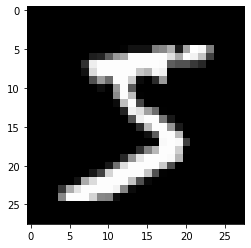

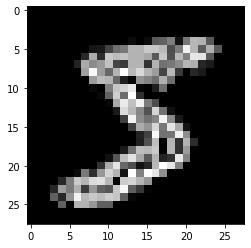

In [4]:
from py.losses.torch import SobelLayer
import torch.nn.functional as F
img = ds_train[0][0].cpu().numpy()
plt.imshow(img.reshape((28,28)), cmap='gray', aspect='equal')
plt.show()
image = F.dropout(torch.from_numpy(img), p=0.2)
image = image.unsqueeze(0)
image = torch.nn.Unflatten(1, (1,28,28))(image)
net = SobelLayer(unflatten=False)
image = net(image)
plt.imshow(image.numpy().squeeze(), cmap='gray', aspect='equal')

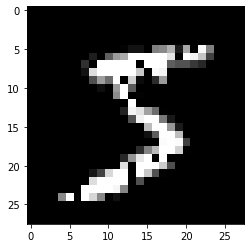

/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


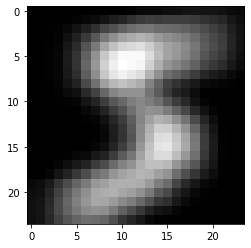

In [5]:
from py.losses.torch import GaussianBlurLayer
img = F.dropout(ds_train[0][0], p=0.2).cpu().numpy()
plt.imshow(img.reshape((28,28)), cmap='gray', aspect='equal')
plt.show()
image = F.dropout(torch.from_numpy(img), p=0.2)
image = image.unsqueeze(0)
image = torch.nn.Unflatten(1, (1,28,28))(image)
net = GaussianBlurLayer(kernel_size=3, unflatten=False)
image = net(image)
plt.imshow(image.numpy().squeeze(), cmap='gray', aspect='equal')
plt.show()

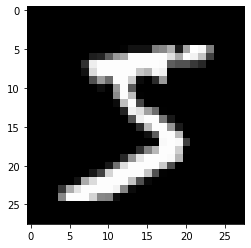

1.0
0.0


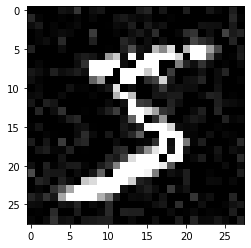

In [15]:
from py.dec.layers.torch import TruncatedGaussianNoise
img = ds_train[0][0].cpu().numpy()
plt.imshow(img.reshape((28,28)), cmap='gray', aspect='equal')
plt.show()
image = F.dropout(torch.from_numpy(img), p=0.2)
image = image.unsqueeze(0)
#image = torch.nn.Unflatten(1, (1,28,28))(image)
net = TruncatedGaussianNoise(shape=784, stddev=0.1, rate=1.0)
image = net(image)
image = torch.nn.Unflatten(1, (28,28))(image)
plt.imshow(image.numpy().squeeze(), cmap='gray', aspect='equal')
print(np.max(image.numpy()))
print(np.min(image.numpy()))

In [13]:
image.numpy().shape

(1, 28, 28)

In [14]:
clustering_model.load_state_dict(torch.load(cl_model_alpha1_param_path))
final_centroids = clustering_model.assignment.cluster_centers.detach().numpy()
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(finetune_ae_feat)
initial_centroids = kmeans.cluster_centers_
#print('Initial Centroids: {}'.format(initial_centroids))
#print('Final Centroids: {}'.format(final_centroids))
delta_centroids = final_centroids-initial_centroids
#print('Delta Centroids: {}'.format(delta_centroids))

In [13]:
image.shape


torch.Size([784, 1, 28, 28])

In [82]:
clustering_model.load_state_dict(torch.load(cl_model_alpha9_param_path))
final_centroids = clustering_model.assignment.cluster_centers.detach().numpy()
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(finetune_ae_feat)
initial_centroids = kmeans.cluster_centers_
#print('Initial Centroids: {}'.format(initial_centroids))
#print('Final Centroids: {}'.format(final_centroids))
delta_centroids = final_centroids-initial_centroids
#print('Delta Centroids: {}'.format(delta_centroids))

In [83]:
# autoencoder.load_state_dict(torch.load(ae_param_ft_path))
# clustering_model = DEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder)
idx = np.random.randint(60000, size=1000)
final_assigments_alpha1 = final_assigments_alpha1[idx]
final_assigments_alpha9 = final_assigments_alpha9[idx]
actual_labels_alpha1 = actual_labels_alpha1[idx]
actual_labels_alpha9 = actual_labels_alpha9[idx]
pretrain_ae_feat = pretrain_ae_feat[idx, :]
finetune_ae_feat = finetune_ae_feat[idx, :]
final_ae_feat_alpha9 = final_ae_feat_alpha9[idx, :]
'''
tsne = TSNE(
    n_components=2,
    random_state=51550,
    n_jobs=-1,
    #verbose=10
    ).fit_transform(z)
print('tsne done')
dbcl_tsne = DBSCAN(
    min_samples=40,
    eps=3,
    n_jobs=-1,
    #verbose=10
    ).fit(tsne)
print('dbscan1 done')
dbcl = DBSCAN(
    #min_samples=5,
    eps=35,
    n_jobs=-1,
    #verbose=10
    ).fit(z)
print('dbscan2 done')'''
N_CLUSTERS = 10
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(finetune_ae_feat)
print('kmeans done')
print('Accuracies obtained')
#labels_list = [dbcl_tsne.labels_, y_pred, dbcl.labels_, kmeans.labels_, y_train]
#descs_list = ['dbscan_tsne', 'dec', 'dbscan', 'kmeans', 'ground_truth']
labels_list = [final_assigments_alpha1, final_assigments_alpha9, kmeans.labels_, actual_labels_alpha1]
descs_list = ['dec_alpha1', 'dec_alpha9', 'kmeans', 'ground_truth']
for labels, desc in zip(labels_list[:-1], descs_list[:-1]):
    n_classes = len(np.unique(labels))
    if n_classes > 1:
        accuracy = my_metrics.acc(actual_labels_alpha1, labels)
        s_accuracy = (n_classes/(n_classes-1))*accuracy-(1/(n_classes-1))
        nmi_score = my_metrics.nmi(actual_labels_alpha1, labels)
        print('\t{}: acc {}, s_acc {}, nmi {}, {} labels'. \
            format(desc, accuracy, s_accuracy, nmi_score, n_classes))

kmeans done
Accuracies obtained
	dec_alpha1: acc 0.875, s_acc 0.8611111111111112, nmi 0.8616027969791727, 10 labels
	dec_alpha9: acc 0.882, s_acc 0.868888888888889, nmi 0.8725508914934126, 10 labels
	kmeans: acc 0.839, s_acc 0.8211111111111111, nmi 0.7827937015989438, 10 labels


In [84]:
## some final stats
autoencoder.load_state_dict(torch.load(ae_alpha1_param_final_path))
if cuda:
    autoencoder.cuda()
    clustering_model.cuda()
autoencoder.eval()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()

r_ds_train = ReconstructedMNIST(reconstructed_imgs=reconstructed, actual=actual_labels_alpha1, cuda=cuda)
ae_predicted = predict(
    ds_train, clustering_model, 1024, silent=True, return_actual=False, cuda=cuda
)
ae_predicted = ae_predicted.cpu().numpy()[idx]


print('Final cycle accuracy is {}\nFinal accuracy is {}'. \
    format(my_metrics.acc(final_assigments_alpha1, ae_predicted), my_metrics.acc(actual_labels_alpha1, final_assigments_alpha1)))

confusion_matrix = sklearn.metrics.confusion_matrix(final_assigments_alpha1, ae_predicted)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_cycle_accuracy_alpha1.png')
plt.close()

confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels_alpha1, final_assigments_alpha1)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_accuracy_alpha1.png')
plt.close()

autoencoder.load_state_dict(torch.load(ae_alpha9_param_final_path))
if cuda:
    autoencoder.cuda()
    clustering_model.cuda()
autoencoder.eval()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()

r_ds_train = ReconstructedMNIST(reconstructed_imgs=reconstructed, actual=actual_labels_alpha9, cuda=cuda)
ae_predicted = predict(
    ds_train, clustering_model, 1024, silent=True, return_actual=False, cuda=cuda
)
ae_predicted = ae_predicted.cpu().numpy()[idx]


print('Final cycle accuracy is {}\nFinal accuracy is {}'. \
    format(my_metrics.acc(actual_labels_alpha9, ae_predicted), my_metrics.acc(actual_labels_alpha9, final_assigments_alpha9)))

confusion_matrix = sklearn.metrics.confusion_matrix(final_assigments_alpha9, ae_predicted)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_cycle_accuracy_alpha9.png')
plt.close()

confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels_alpha9, final_assigments_alpha9)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_accuracy_alpha9.png')
plt.close()

Final cycle accuracy is 1.0
Final accuracy is 0.875
Final cycle accuracy is 0.882
Final accuracy is 0.882


/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 17%|▏| 10000/60000 [00:16<01:20, 618.65b
 17%|▏| 10000/60000 [00:15<01:15, 658.72b


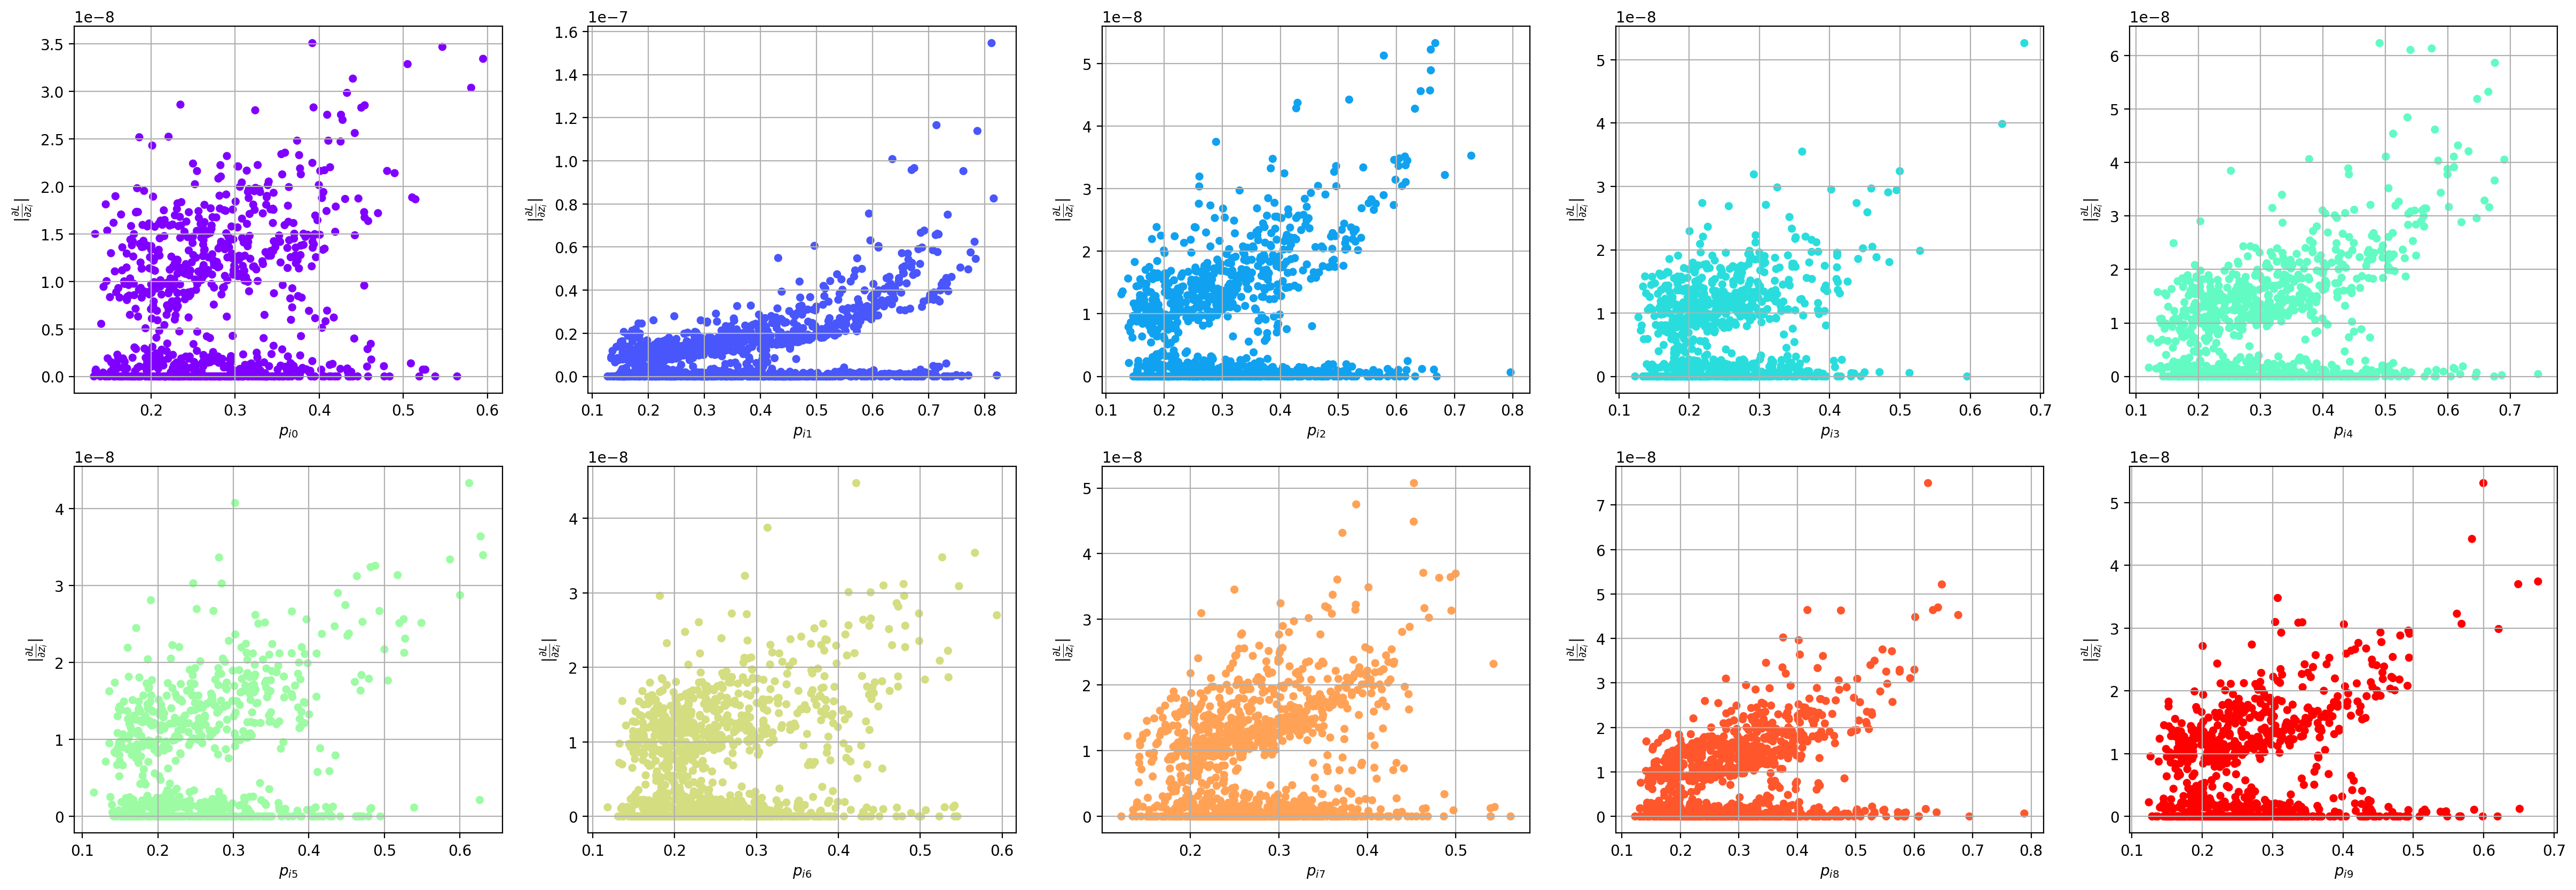

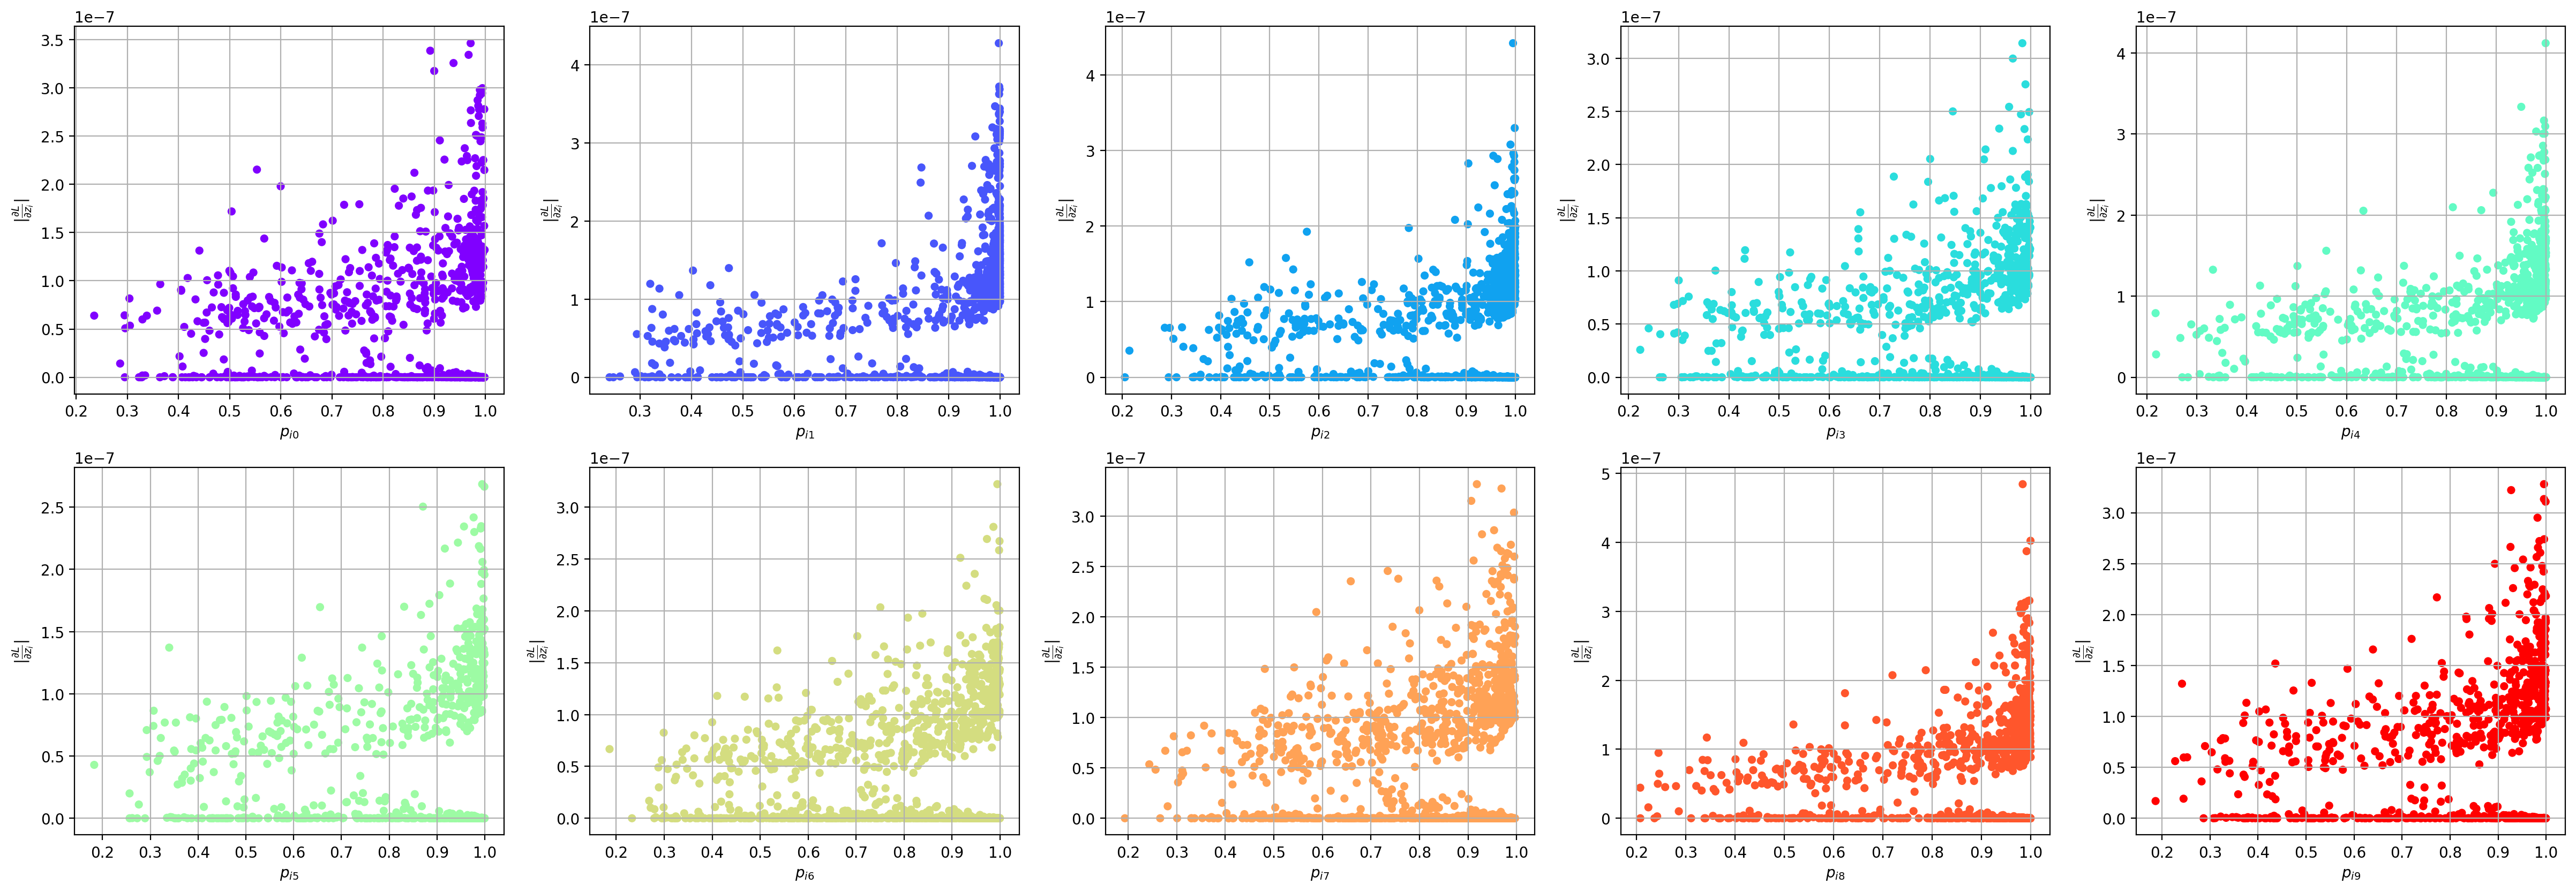

In [85]:
## Gradients plot
autoencoder.load_state_dict(torch.load(ae_param_ft_path))
loss_function = torch.nn.KLDivLoss(size_average=False)
for alpha in [1, 9]:
    model = DEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder, alpha=alpha)
    cluster_centers = torch.tensor(
        initial_centroids, dtype=torch.float, requires_grad=True
    )
    if cuda:
        model.cuda()
        cluster_centers.cuda()
    with torch.no_grad():
        # initialise the cluster centers
        model.state_dict()["assignment.cluster_centers"].copy_(cluster_centers)
        
    static_dataloader = DataLoader(
        ds_train,
        batch_size=1,
        collate_fn=default_collate,
        pin_memory=False,
        sampler=None,
        shuffle=False,
    )
    data_iterator = tqdm(
        static_dataloader,
        leave=True,
        unit="batch",
        postfix=None,
        disable=False,
    )
    targets = []
    gradients = []
    qs = []
    model.train()
    for index, batch in enumerate(data_iterator):
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(
            batch
        ) == 2:
            batch, _ = batch  # if we have a prediction label, strip it away
        if cuda:
            batch = batch.cuda(non_blocking=True)
        features = autoencoder.encoder(batch).detach()
        features.requires_grad = True
        output = model.assignment(features)
        
        target = target_distribution(output).detach()
        loss = loss_function(output.log(), target) / output.shape[0]
        loss.backward()
        
        targets.append(target.cpu().numpy())
        gradients.append(np.linalg.norm(features.grad.cpu().numpy()))
        qs.append(output.detach().cpu().numpy())
        if index > 9999:
            break

    initial_pred = np.squeeze(np.array(targets)).argmax(1)
    allgrad = np.squeeze(np.array(gradients))
    qij = np.squeeze(np.array(qs))
    fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                            figsize=(30, 10),
                            squeeze=True,
                            facecolor='white',
                            dpi=200)
    k=0
    colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
    for i in range(2):
        for j in range(int(N_CLUSTERS/2)):
            idx = (initial_pred == k)
            ax = axs[i, j]
            scatter = ax.scatter(
                qij[idx, k],
                allgrad[idx],
                color=colors[k],
                s=[20]*len(qij[idx, k]),
            )
            ax.set_xlabel(r'$p_{i%d}$' % k)
            ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
            ax.grid()
            k+=1
    plt.savefig(results_path/'initial_gradients_alpha{}.png'.format(alpha),
                facecolor=fig.get_facecolor(),
                edgecolor='none')

Visualizing dec_alpha1 labels


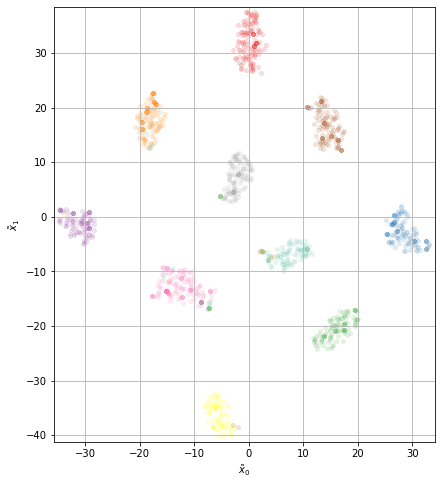

Visualizing dec_alpha9 labels


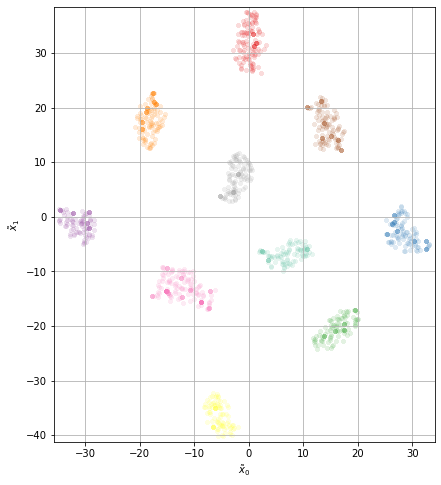

Visualizing kmeans labels


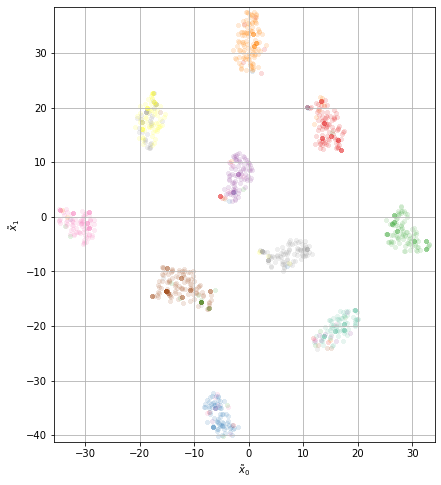

Visualizing ground_truth labels


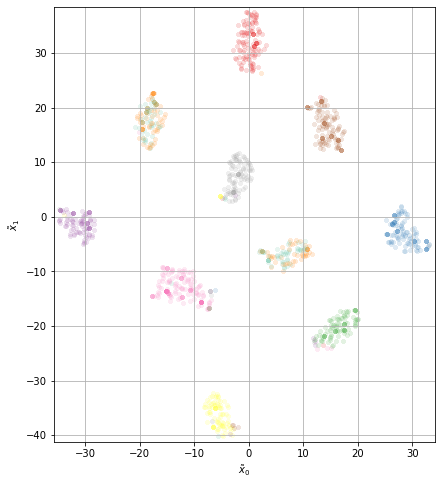

In [86]:
delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(final_ae_feat_alpha9)

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(final_ae_feat_alpha9[idx, :]))
        a = np.concatenate((final_ae_feat_alpha9, centroids), axis=0)
    
    # tsne = TSNE(n_components=2,
    #             n_jobs=-1,
    #             random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(final_ae_feat_alpha9)], columns=['x0', 'x1'])
    # centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    # centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    # centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
    y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        # dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
        #     shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

Visualizing dec_alpha1 labels


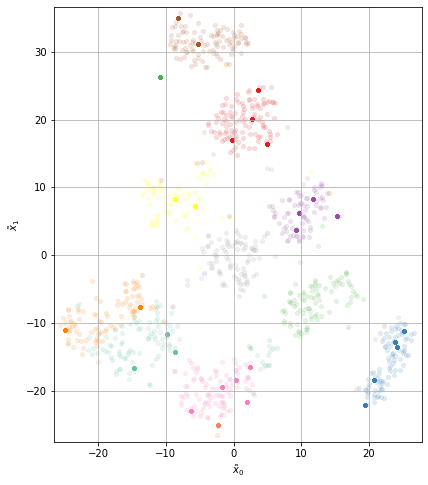

Visualizing dec_alpha9 labels


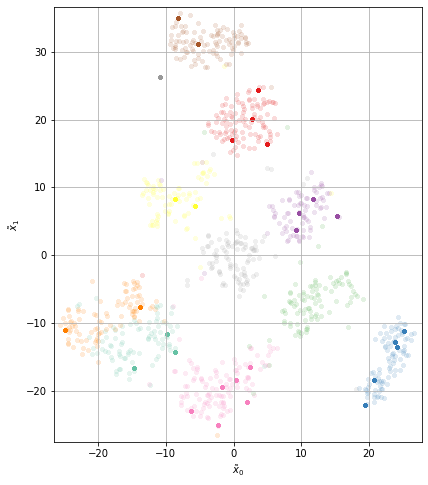

Visualizing kmeans labels


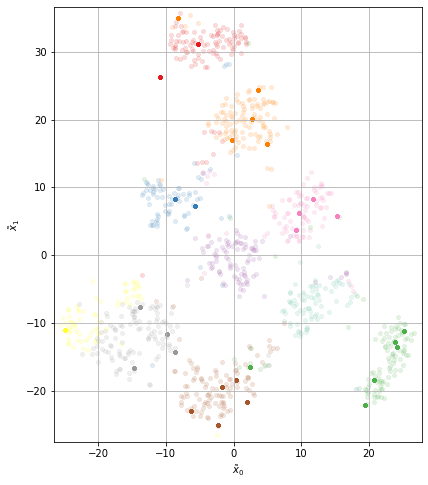

Visualizing ground_truth labels


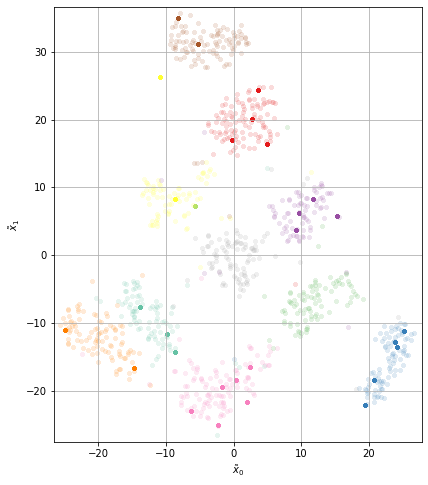

In [87]:
delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(finetune_ae_feat)

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(finetune_ae_feat[idx, :]))
        a = np.concatenate((finetune_ae_feat, centroids), axis=0)
    
    # tsne = TSNE(n_components=2,
    #             n_jobs=-1,
    #             random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(finetune_ae_feat)], columns=['x0', 'x1'])
    # centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    # centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    # centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
    y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        # dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
        #     shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'finetune_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

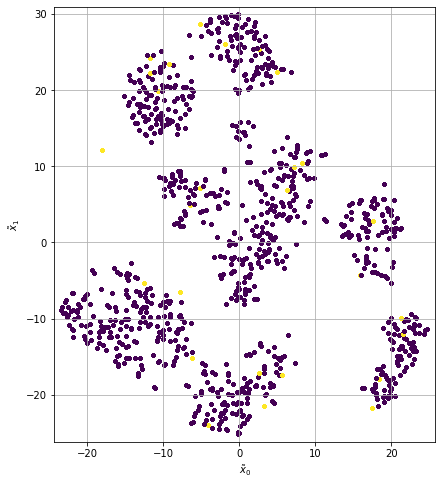

In [88]:
delta = 1.0
tsne = TSNE(n_components=2, n_jobs=-1, random_state=51550).fit_transform(pretrain_ae_feat)
points = pd.DataFrame(tsne, columns=['x0', 'x1'])
fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
artist = dsshow(points, ds.Point('x0','x1'), ds.count(), ax=ax,
      shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
ax.grid()
ax.set_xlabel(r'$\tilde{x}_0$')
ax.set_ylabel(r'$\tilde{x}_1$')
plt.savefig(results_path/'pretrain_tsne_space.png')
#plt.close()

In [ ]:
delta = 0.1
    
points = pd.DataFrame(final_ae_feat_alpha9, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(final_ae_feat_alpha9[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in range(10)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
            y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'cluster_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

In [ ]:
delta = 0.1
    
points = pd.DataFrame(finetune_ae_feat, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(finetune_ae_feat[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in range(10)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
            y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'finetune_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

In [ ]:
delta = 0.1
    
points = pd.DataFrame(pretrain_ae_feat, columns=['z{}'.format(i) for i in range(10)])

fig, axs = plt.subplots(dims[-1], dims[-1],
                        figsize=(8*dims[-1], 4*dims[-1]),
                        squeeze=False,
                        facecolor='white',
                        dpi=200)
for i in range(dims[-1]):
    for j in range(dims[-1]):
        ax = axs[i, j]
        x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
        y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
        if i!=j:
            artist = dsshow(points, ds.Point('z{}'.format(i),'z{}'.format(j)), ds.count(), ax=axs[i, j],
                  shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
        ax.grid()
        ax.set_xlabel(r'$z_{%d}$' % i)
        ax.set_ylabel(r'$z_{%d}$' % j)
plt.savefig(results_path/'pretrain_feature_space_{}.png'.format(desc),
            facecolor=fig.get_facecolor(),
            edgecolor='none')
plt.close()

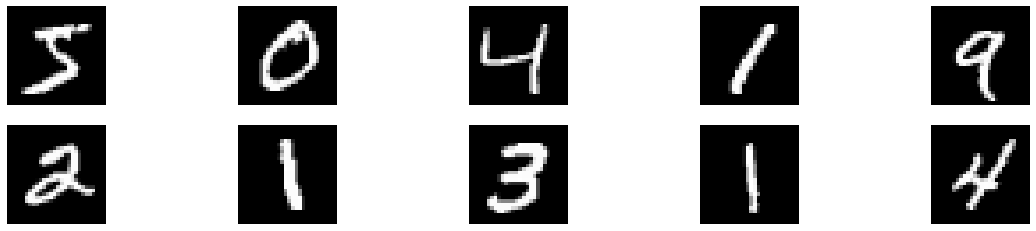

In [89]:
## Example MNIST digits
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

examples = [ds_train[i][0].cpu().numpy() for i in range(10)]

for example in examples:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_orig.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

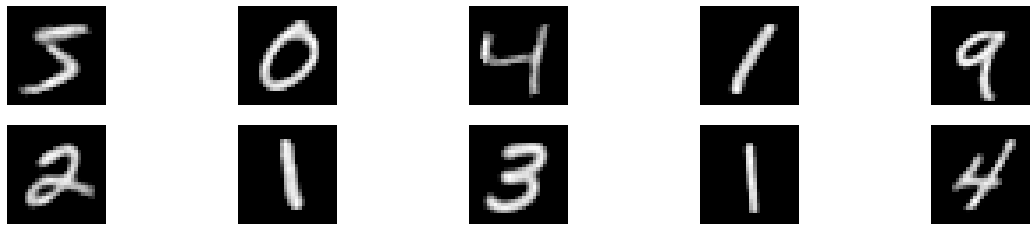

In [90]:
## Example MNIST digits from pretrained autoencoder
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

autoencoder.load_state_dict(torch.load(ae_param_path))
if cuda:
    autoencoder.cuda()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()
examples = [reconstructed[i] for i in range(10)]

for example in examples:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_pretrain.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

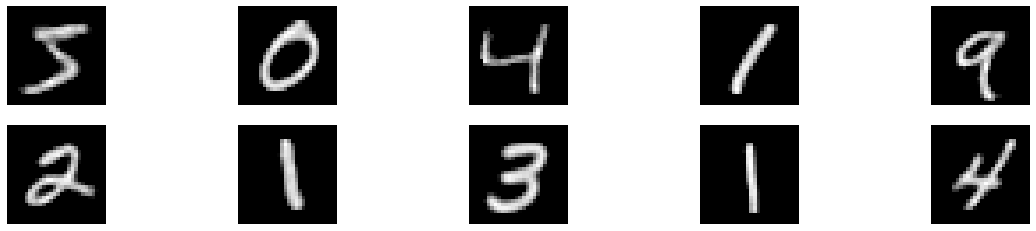

In [91]:
## Example MNIST digits from finetuned autoencoder
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

autoencoder.load_state_dict(torch.load(ae_param_ft_path))
if cuda:
    autoencoder.cuda()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()
examples = [reconstructed[i] for i in range(10)]

for example in examples:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_pretrain.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

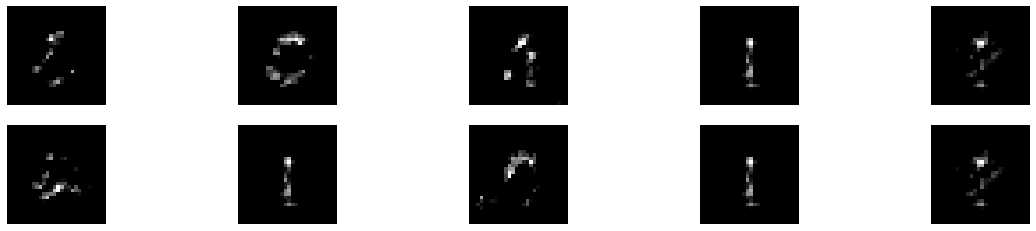

In [92]:
## Example MNIST digits from final model
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

autoencoder.load_state_dict(torch.load(ae_alpha1_param_final_path))
if cuda:
    autoencoder.cuda()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()
examples = [reconstructed[i] for i in range(10)]

for example in examples:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_pretrain.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

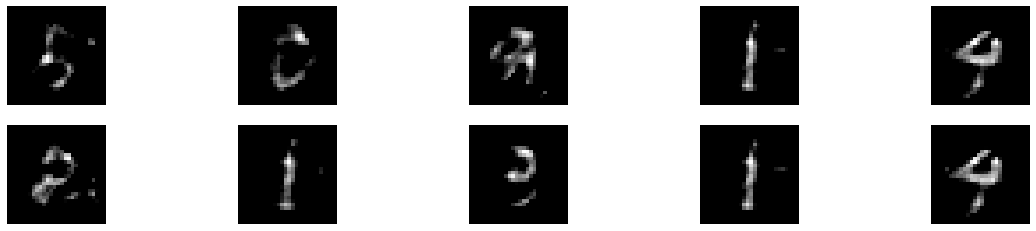

In [93]:
## Example MNIST digits from final model
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

autoencoder.load_state_dict(torch.load(ae_alpha9_param_final_path))
if cuda:
    autoencoder.cuda()
reconstructed = []
dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
    if cuda:
        batch = batch.cuda(non_blocking=True)
    reconstructed.append(autoencoder(batch).detach().cpu())
reconstructed = torch.cat(reconstructed).cpu().numpy()
examples = [reconstructed[i] for i in range(10)]

for example in examples:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_pretrain.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')